In [1]:
import pytest
import numpy as np
from climlab_rrtmg import rrtmg_lw, rrtmg_sw
from matplotlib import pyplot as plt
import random

# Specific heat at constant pressure
cp = 1004.

# Set up the pressure domain
ps = 1000. #  Surface pressure in hPa
# RRTM code expects arrays with (ncol, nlay)
# and with pressure decreasing from surface at element 0
ncol = 1
nlay = 30
deltap = ps / nlay  # pressure interval
plev = np.linspace(ps, 0., nlay+1)  # pressure bounds
plev = plev[np.newaxis, ...]
play = np.linspace(ps-deltap/2., deltap/2., nlay)
play = play[np.newaxis, ...]
# Set the temperatures
#  Using a linearly decreasing temperature from surface to TOA
tsfc = 288.
tlay = np.linspace(288.-10., 200., nlay)
tlay = tlay[np.newaxis, ...]
tlev = np.linspace(288., 200., nlay+1)
tlev = tlev[np.newaxis, ...]

# atmospheric composition
# specific humidity profile computed from those temperatures using Manabe's
# fixed relative humidity profile
specific_humidity = np.array([4.13141097e-03, 3.41509495e-03, 2.81099479e-03, 2.30359570e-03,
       1.87920573e-03, 1.52578624e-03, 1.23279279e-03, 9.91026303e-04,
       7.92494475e-04, 6.30283118e-04, 4.98437246e-04, 3.91851633e-04,
       3.06170488e-04, 2.37695932e-04, 1.83304857e-04, 1.40373783e-04,
       1.06711275e-04, 8.04974602e-05, 6.02302082e-05, 4.46774859e-05,
       3.28354282e-05, 2.38916443e-05, 1.71932832e-05, 1.22193649e-05,
       8.55682965e-06, 5.87957411e-06, 5.00000000e-06, 5.00000000e-06,
       5.00000000e-06, 5.00000000e-06])
# Convert to volume mixing ratio from mass mixing ratio
#  just multiplying by ratio of molecular weights of dry air and H2O
h2ovmr = specific_humidity * 28.97 / 18.01528
h2ovmr = h2ovmr[np.newaxis, ...]
#  A global-mean ozone climatology
o3vmr = np.array([2.25573888e-08, 2.38730436e-08, 2.52586476e-08, 2.66442517e-08,
       2.80298557e-08, 2.97254145e-08, 3.14254923e-08, 3.31238355e-08,
       3.46767916e-08, 3.62297478e-08, 3.76122833e-08, 3.86410454e-08,
       3.96698075e-08, 4.08899052e-08, 4.21303310e-08, 4.39781220e-08,
       4.60528063e-08, 4.87636254e-08, 5.16974065e-08, 5.57122567e-08,
       6.17914190e-08, 7.15771368e-08, 9.29020109e-08, 1.29109217e-07,
       1.75914529e-07, 2.45552383e-07, 3.92764464e-07, 7.61726407e-07,
       2.25137178e-06, 7.27500161e-06])
o3vmr = o3vmr[np.newaxis, ...]
# Other values taken from the AquaPlanet Experiment protocols,
# except for O2 which is set the realistic value 0.21
co2vmr = 348. / 1E6 * np.ones_like(play)
ch4vmr = 1650. / 1E9 * np.ones_like(play)
n2ovmr = 306. / 1E9 * np.ones_like(play)
o2vmr = 0.21 * np.ones_like(play)
cfc11vmr = 0. * np.ones_like(play)
cfc12vmr = 0. * np.ones_like(play)
cfc22vmr = 0. * np.ones_like(play)
ccl4vmr = 0. * np.ones_like(play)

#  Cloud parameters
cloud_level_index = 8
cldfrac = 0.5*np.exp(-(play-play[0,cloud_level_index])**2/(2*25.)**2)  # Layer cloud fraction: a Gaussian centered on a pressure level
clwp = 60. * np.ones_like(play)  # in-cloud liquid water path (g/m2)
ciwp = 0. * np.ones_like(play)   # in-cloud ice water path (g/m2)
relq = 14. * np.ones_like(play) # Cloud water drop effective radius (microns)
reic = 0. * np.ones_like(play)  # Cloud ice particle effective size (microns)


In [2]:
nbndsw = int(rrtmg_sw.parrrsw.nbndsw)
naerec = int(rrtmg_sw.parrrsw.naerec)
ngptsw = int(rrtmg_sw.parrrsw.ngptsw)
nbndlw = int(rrtmg_lw.parrrtm.nbndlw)
ngptlw = int(rrtmg_lw.parrrtm.ngptlw)
g2band_sw = np.array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
        8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13])
g2band_lw = np.array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13,
       14, 14, 15, 15])

In [3]:
cldfrac = cldfrac**0.05*0.5

Text(0.5, 1.0, 'Cloud Fraction')

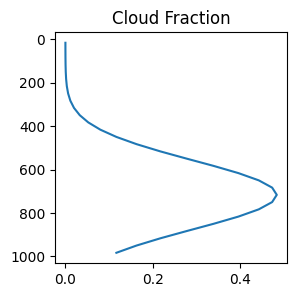

In [4]:
plt.figure(figsize=(3,3))
plt.plot(cldfrac[0],0.5*(plev[0][1:]+plev[0][:-1]))
plt.gca().invert_yaxis()
plt.title('Cloud Fraction')

In [5]:
# Constants for latitude and day-of-year dependent decorrelation length (Oreopolous et al., 2012)
am1 = 1.4315
am2 = 2.1219
am4 = -25.584
amr = 7.0

def get_alpha(iplon, nlayers, idcor, decorr_con, dz, lat, juldat, cldfrac):
    # we only do icld = 4!!
    # Calculate decorrelation length
    if idcor == 1:
        # Calculate day-of-year dependent component
        if juldat > 181:
            am3 = -4 * amr / 365 * (juldat - 272)
        else:
            am3 = 4 * amr / 365 * (juldat - 91)
        # Calculate latitude dependent decorrelation length in meters
        decorr_lat = am1 + am2 * np.exp(-((lat - am3) ** 2) / (am4 ** 2))
        decorr_len = decorr_lat * 1e3
    else:
        decorr_len = decorr_con
    
    decorr_inv = 1 / decorr_len if decorr_len >= 0 else 1.0

    alpha = np.zeros(nlayers)
    # Calculate alpha for each layer Exponential cloud overlap
    alpha[0] = 0.0
    for k in range(1, nlayers):
        alpha[k] = np.exp(-0.5 * (dz[k] + dz[k-1]) * decorr_inv)
    
    return alpha
    
def sample_exp_overlap(nsubcol,nlayers,cldf,alpha,seed=0):
    np.random.seed(seed)
    CDF = np.zeros((nsubcol, nlayers))
    CDF2 = np.zeros((nsubcol, nlayers))

    for isubcol in range(nsubcol):
        for ilev in range(nlayers):
            rand_num =  np.random.uniform(0,1,1)[0]
            CDF[isubcol, ilev] = rand_num
            rand_num =  np.random.uniform(0,1,1)[0]
            CDF2[isubcol, ilev] = rand_num
    # Generate vertical correlations in random number arrays: bottom to top
    for ilev in range(1, nlayers):
        # Assuming spread function is defined to work similarly to Fortran spread
        # Assuming alpha is an array of values for each layer
        condition = CDF2[:, ilev] < alpha[ilev]
        CDF[:, ilev][condition] = CDF[:, ilev - 1][condition]
        
    # Initialize the 'iscloudy' array with the same shape as 'CDF'
    iscloudy = np.zeros(CDF.shape, dtype=bool)
    for ilev in range(nlayers):  # Python is 0-indexed
        # The 'np.newaxis' is used to broadcast 'cldf' across the 'nsubcol' dimension
        threshold = 1.0 - cldf[ilev]
        iscloudy[:, ilev] = (CDF[:, ilev] >= threshold)
    iscloudy = np.float_(iscloudy)
    return CDF,iscloudy

def exponential_sw(ncol, nlay, dz, permuteseed, play,
                        cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc):
                        # latter four has shape band, 1, nlay
    alpha = get_alpha(None, nlay, 1, None, dz, 0, 180, cldfrac.flatten())
    tauc_g,ssac_g,asmc_g,fsfc_g = np.zeros((ngptsw,1,nlay)),np.zeros((ngptsw,1,nlay)),np.zeros((ngptsw,1,nlay)),np.zeros((ngptsw,1,nlay))
    for i in range(ngptsw):
        tauc_g[i] = tauc[g2band_sw[i]]
        ssac_g[i] = ssac[g2band_sw[i]]
        asmc_g[i] = asmc[g2band_sw[i]]
        fsfc_g[i] = fsfc[g2band_sw[i]]
    CDF,iscloudy = sample_exp_overlap(ngptsw,nlay,cldfrac.flatten(),alpha,permuteseed)
    iscloudy = iscloudy[:,None,:]
    #print(cldfrac.shape,iscloudy.shape,tauc.shape,ciwp.shape,reic.shape, ssac.shape, asmc.shape, fsfc.shape)
    zeroarr = np.zeros((ngptsw,1,nlay))
    cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl, ssacmcl, asmcmcl, fsfcmcl = \
        zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy()
    cldfmcl[np.where(iscloudy==1)] = 1
    taucmcl[np.where(iscloudy==1)] = tauc_g[np.where(iscloudy==1)]
    ssacmcl[np.where(iscloudy==1)] = ssac_g[np.where(iscloudy==1)]
    asmcmcl[np.where(iscloudy==1)] = asmc_g[np.where(iscloudy==1)]
    fsfcmcl[np.where(iscloudy==1)] = fsfc_g[np.where(iscloudy==1)]
    ciwpmcl[np.where(iscloudy==1)] += ((ciwpmcl*0+1)*ciwp[None,:])[np.where(iscloudy==1)]
    clwpmcl[np.where(iscloudy==1)] += ((clwpmcl*0+1)*clwp[None,:])[np.where(iscloudy==1)]

    return (cldfmcl, ciwpmcl, clwpmcl, reic.copy(), relq.copy(), taucmcl, ssacmcl, asmcmcl, fsfcmcl)

def exponential_lw(ncol, nlay, dz, permuteseed, play,
                        cldfrac, ciwp, clwp, reic, relq, tauc):
                        # latter four has shape band, 1, nlay
    alpha = get_alpha(None, nlay, 1, None, dz, 0, 180, cldfrac.flatten())
    tauc_g = np.zeros((ngptlw,1,nlay))
    for i in range(ngptlw):
        tauc_g[i] = tauc[g2band_lw[i]]
    CDF,iscloudy = sample_exp_overlap(ngptlw,nlay,cldfrac.flatten(),alpha,permuteseed)
    iscloudy = iscloudy[:,None,:]
    #print(cldfrac.shape,iscloudy.shape,tauc.shape,ciwp.shape,reic.shape, ssac.shape, asmc.shape, fsfc.shape)
    zeroarr = np.zeros((ngptlw,1,nlay))
    cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl = \
        zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy(),zeroarr.copy()
    cldfmcl[np.where(iscloudy==1)] = 1
    taucmcl[np.where(iscloudy==1)] = tauc_g[np.where(iscloudy==1)]
    ciwpmcl[np.where(iscloudy==1)] += ((ciwpmcl*0+1)*ciwp[None,:])[np.where(iscloudy==1)]
    clwpmcl[np.where(iscloudy==1)] += ((clwpmcl*0+1)*clwp[None,:])[np.where(iscloudy==1)]

    return (cldfmcl, ciwpmcl, clwpmcl, reic.copy(), relq.copy(), taucmcl)

In [12]:
def dz_from_p(p_lev,ptoa=1e-5): # using _bounding_ pressure (mb) to approximate layer thickness in meters
    # assume a non-zero top of atmosphere pressure
    # source of fit: ERA5 2022 annual zonal mean geopotential height on pressure level over 0 degree latitude
    fit = np.array([-7193.75219011, 50217.56455353])
    p_lev[p_lev==0] += ptoa
    z_lev = fit[0]*np.log(p_lev)+fit[1]
    dz = z_lev[:-1]-z_lev[1:]
    return dz
dz = dz_from_p(plev[0])

Do clear sky calculation once

In [13]:
icld = 0    # Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random] 3: Maximum

nbndsw = int(rrtmg_sw.parrrsw.nbndsw)
naerec = int(rrtmg_sw.parrrsw.naerec)
ngptsw = int(rrtmg_sw.parrrsw.ngptsw)
#  Initialize absorption data
rrtmg_sw.climlab_rrtmg_sw_ini(cp)
#  Lots of RRTMG parameters
#icld = 0    # Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random] 3: Maximum
irng = 1  # more monte carlo stuff
permuteseed = 150

dyofyr = 0       # day of the year used to get Earth/Sun distance (if not adjes)
inflgsw  = 2
iceflgsw = 1
liqflgsw = 1
tauc_sw = 2
ssac_sw = 0.2  # In-cloud single scattering albedo
asmc_sw = 0.5  # In-cloud asymmetry parameter
fsfc_sw = 0.5  # In-cloud forward scattering fraction (delta function pointing forward "forward peaked scattering")
# AEROSOLS
iaer = 0   #! Aerosol option flag
            #!    0: No aerosol
            #!    6: ECMWF method: use six ECMWF aerosol types input aerosol optical depth at 0.55 microns for each aerosol type (ecaer)
            #!    10:Input aerosol optical properties: input total aerosol optical depth, single scattering albedo and asymmetry parameter (tauaer, ssaaer, asmaer) directly
tauaer = 0. * np.ones_like(play)   # Aerosol optical depth (iaer=10 only), Dimensions,  (ncol,nlay,nbndsw)] #  (non-delta scaled)
#  broadcast and transpose to get [ncol,nlay,nbndsw]
tauaer = np.transpose(tauaer * np.ones([nbndsw,ncol,nlay]), (1,2,0))
ssaaer = 0. * np.ones_like(play)   # Aerosol single scattering albedo (iaer=10 only), Dimensions,  (ncol,nlay,nbndsw)] #  (non-delta scaled)
#  broadcast and transpose to get [ncol,nlay,nbndsw]
ssaaer = np.transpose(ssaaer * np.ones([nbndsw,ncol,nlay]), (1,2,0))
asmaer = 0. * np.ones_like(play)   # Aerosol asymmetry parameter (iaer=10 only), Dimensions,  (ncol,nlay,nbndsw)] #  (non-delta scaled)
#  broadcast and transpose to get [ncol,nlay,nbndsw]
asmaer = np.transpose(asmaer * np.ones([nbndsw,ncol,nlay]), (1,2,0))
ecaer  = 0. * np.ones_like(play)   # Aerosol optical depth at 0.55 micron (iaer=6 only), Dimensions,  (ncol,nlay,naerec)] #  (non-delta scaled)
#  broadcast and transpose to get [ncol,nlay,naerec]
ecaer = np.transpose(ecaer * np.ones([naerec,ncol,nlay]), (1,2,0))
#  These cloud arrays have an extra dimension for number of bands
# in-cloud optical depth [nbndsw,ncol,nlay]
tauc = tauc_sw * np.ones_like(play)
#  broadcast to get [nbndsw,ncol,nlay]
tauc = tauc * np.ones([nbndsw,ncol,nlay])

# In-cloud single scattering albedo, same operation
ssac = ssac_sw * np.ones_like(play) * np.ones([nbndsw,ncol,nlay])
# In-cloud asymmetry parameter
asmc = asmc_sw * np.ones_like(play) * np.ones([nbndsw,ncol,nlay])
# In-cloud forward scattering fraction (delta function pointing forward "forward peaked scattering")
fsfc = fsfc_sw * np.ones_like(play) * np.ones([nbndsw,ncol,nlay])
# insolation
scon = 1365.2  # solar constant
coszen = 1/4  # cosine of zenith angle
adjes = 1.  # instantaneous irradiance = scon * eccentricity_factor
dyofyr = 0       # day of the year used to get Earth/Sun distance (if not adjes)
# new arguments for RRTMG_SW version 4.0
isolvar = -1    # ! Flag for solar variability method
indsolvar = np.ones(2)      # Facular and sunspot amplitude scale factors (isolvar=1),
                            # or Mg and SB indices (isolvar=2)
bndsolvar = np.ones(nbndsw) # Solar variability scale factors for each shortwave band
solcycfrac = 1.              # Fraction of averaged solar cycle (0-1) at current time (isolvar=1)

# surface albedo
aldif = 0.3
aldir = 0.3
asdif = 0.3
asdir = 0.3

#  Call the Monte Carlo Independent Column Approximation (McICA, Pincus et al., JC, 2003)
(cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl,
ssacmcl, asmcmcl, fsfcmcl) = rrtmg_sw.climlab_mcica_subcol_sw(
                ncol, nlay, icld, permuteseed, irng, play,
                cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc)

(swuflx, swdflx, swhr, swuflxc, swdflxc, swhrc) = \
        rrtmg_sw.climlab_rrtmg_sw(ncol, nlay, icld, iaer,
            play, plev, tlay, tlev, tsfc,
            h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
            asdir, asdif, aldir, aldif,
            coszen, adjes, dyofyr, scon, isolvar,
            inflgsw, iceflgsw, liqflgsw, cldfmcl,
            taucmcl, ssacmcl, asmcmcl, fsfcmcl,
            ciwpmcl, clwpmcl, reicmcl, relqmcl,
            tauaer, ssaaer, asmaer, ecaer,
            bndsolvar, indsolvar, solcycfrac)

clearswdflux = swdflx.copy()

In [14]:
np.max(taucmcl)

0.0

Do 200 simulations for each of 3 overlap methods.

In [15]:
nrun = 200 # number of simulations

CLDF = [[],[],[],[]]
SWD = [[],[],[],[]]

for icld in (1,2,3,4): # Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random] 3: Maximum
    for permuteseed in range(nrun): # different random seed in each run
        # other parameters are the same as clear run
        # Call the Monte Carlo Independent Column Approximation (McICA, Pincus et al., JC, 2003)
        if icld != 4:
            (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl,
            ssacmcl, asmcmcl, fsfcmcl) = rrtmg_sw.climlab_mcica_subcol_sw(
                            ncol, nlay, icld, permuteseed*(1000+icld), irng, play,
                            cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc)
        else:
            (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl, ssacmcl, asmcmcl, fsfcmcl) = exponential_sw(ncol, nlay, dz, permuteseed, play, cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc)

        (swuflx, swdflx, swhr, swuflxc, swdflxc, swhrc) = \
                rrtmg_sw.climlab_rrtmg_sw(ncol, nlay, icld, iaer,
                    play, plev, tlay, tlev, tsfc,
                    h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                    asdir, asdif, aldir, aldif,
                    coszen, adjes, dyofyr, scon, isolvar,
                    inflgsw, iceflgsw, liqflgsw, cldfmcl,
                    taucmcl, ssacmcl, asmcmcl, fsfcmcl,
                    ciwpmcl, clwpmcl, reicmcl, relqmcl,
                    tauaer, ssaaer, asmaer, ecaer,
                    bndsolvar, indsolvar, solcycfrac)
        CLDF[icld-1].append(cldfmcl)
        SWD[icld-1].append(swdflx)

CLDF = np.array(CLDF) # all binary cloud profiles
SWD = np.array(SWD) # all flux profiles
CLDF.shape,SWD.shape

((4, 200, 112, 1, 30), (4, 200, 1, 31))

In [16]:

LWU = [[],[],[],[]]

nbndlw = int(rrtmg_lw.parrrtm.nbndlw)
ngptlw = int(rrtmg_lw.parrrtm.ngptlw)
#  Initialize absorption data
rrtmg_lw.climlab_rrtmg_lw_ini(cp)

inflglw  = 2
iceflglw = 1
liqflglw = 1
idrv = 0

tauc_lw = 100


tauc_lw = tauc_lw * np.ones_like(play)
#  broadcast to get [nbndlw,ncol,nlay]
tauc_lw = tauc_lw * np.ones([nbndlw,ncol,nlay])
# Aerosol optical depth at mid-point of LW spectral bands [ncol,nlay,nbndlw]
tauaer_lw = 0.001 * np.ones_like(play)
#  broadcast and transpose to get [ncol,nlay,nbndlw]
tauaer_lw = np.transpose(tauaer_lw * np.ones([nbndlw,ncol,nlay]), (1,2,0))

# surface emissivity
emis = 1. * np.ones((ncol,nbndlw))

for icld in (1,2,3,4): # Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random] 3: Maximum
    for permuteseed in range(nrun): # different random seed in each run
        # other parameters are the same as clear run
        # Call the Monte Carlo Independent Column Approximation (McICA, Pincus et al., JC, 2003)
        if icld != 4:
            #  Call the Monte Carlo Independent Column Approximation (McICA, Pincus et al., JC, 2003)
            (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl) = \
                rrtmg_lw.climlab_mcica_subcol_lw(
                            ncol, nlay, icld,
                            permuteseed+150, irng, play,
                            cldfrac, ciwp, clwp, reic, relq, tauc_lw)
        else:
            (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl) = exponential_lw(ncol, nlay, dz, permuteseed+150, play, cldfrac, ciwp, clwp, reic, relq, tauc_lw)
        
        ispec = 1
        (olr_sr, uflx, dflx, hr, uflxc, dflxc, hrc, duflx_dt, duflxc_dt) = \
                rrtmg_lw.climlab_rrtmg_lw(ncol, nlay, icld, ispec, idrv,
                        play, plev, tlay, tlev, tsfc,
                        h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                        cfc11vmr, cfc12vmr, cfc22vmr, ccl4vmr, emis,
                        inflglw, iceflglw, liqflglw, cldfmcl,
                        taucmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl,
                        tauaer_lw)

        LWU[icld-1].append(uflx)

LWU = np.array(LWU) # all flux profiles
LWU.shape

(4, 200, 1, 31)

In [17]:
types = ['0. Clear','1. Random','2. Maximum_random','3. Maximum','4. Exponential']

Text(0.5, 1.05, 'Downward shortwave flux: 200 McICA runs and average')

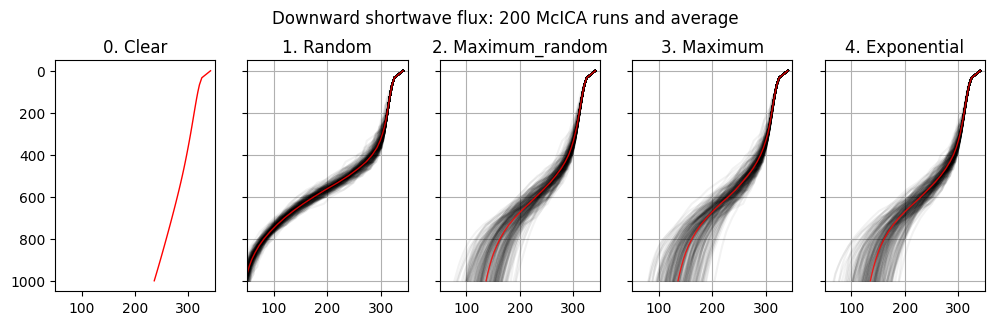

In [18]:
# flux profiles
fig,axes = plt.subplots(1,5,figsize=(12,3),sharey=True,sharex=True)
axes[0].plot(clearswdflux[0],plev[0],color='red',linewidth=1)
axes[0].set_title(types[0])
axes[0].invert_yaxis()
axes[0].set_xlim([50,350])
for i in range(1,5):
    axes[i].plot(SWD[i-1][:,0].T,plev[0],color='black',alpha=0.05)
    axes[i].plot(np.mean(SWD[i-1][:,0],axis=(0)),plev[0],color='red',linewidth=1,alpha=0.8)
    axes[i].set_title(types[i])
    axes[i].set_xlim([50,350])
    axes[i].grid()
plt.suptitle(f'Downward shortwave flux: {nrun} McICA runs and average',y=1.05)


Text(0.5, 1.05, 'Upward longwave flux: 200 McICA runs and average')

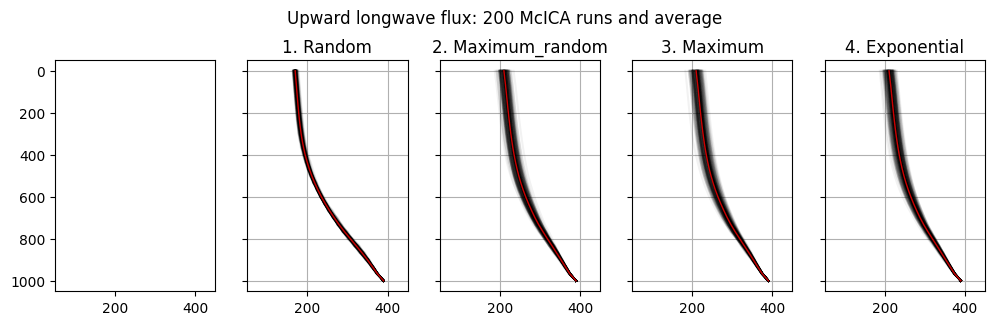

In [19]:
# flux profiles
fig,axes = plt.subplots(1,5,figsize=(12,3),sharey=True,sharex=True)
#axes[0].plot(clearswdflux[0],plev[0],color='red',linewidth=1)
#axes[0].set_title(types[0])
axes[0].invert_yaxis()
axes[0].set_xlim([50,450])
for i in range(1,5):
    axes[i].plot(LWU[i-1][:,0].T,plev[0],color='black',alpha=0.05)
    axes[i].plot(np.mean(LWU[i-1][:,0],axis=(0)),plev[0],color='red',linewidth=1,alpha=0.8)
    axes[i].set_title(types[i])
    axes[i].set_xlim([50,450])
    axes[i].grid()
plt.suptitle(f'Upward longwave flux: {nrun} McICA runs and average',y=1.05)


plots in ppt

Text(0, 0.5, 'level')

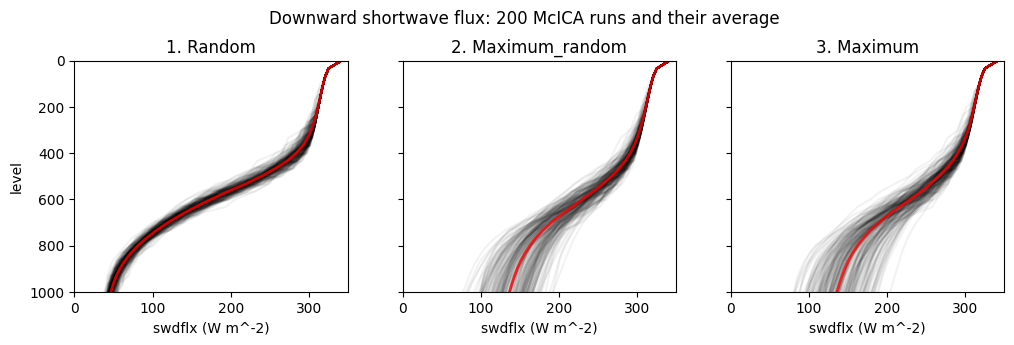

In [20]:
# flux profiles
fig,axes = plt.subplots(1,3,figsize=(12,3),sharey=True)
axes[0].invert_yaxis()
for i in range(0,3):
    axes[i].plot(SWD[i][:,0].T,plev[0],color='black',alpha=0.05)
    axes[i].plot(np.mean(SWD[i][:,0],axis=(0)),plev[0],color='red',linewidth=2,alpha=0.8)
    axes[i].set_title(types[i+1])
    axes[i].set_xlim([0,350])
    axes[i].set_ylim([1000,0])
    axes[i].set_xlabel('swdflx (W m^-2)')
plt.suptitle(f'Downward shortwave flux: {nrun} McICA runs and their average',y=1.05)
axes[0].set_ylabel('level')

# 5 subplots for-loop
for i in range(1,5):
    axes[i].plot(SWD[i-1][:,0].T,plev[0],color='black',alpha=0.05)
    axes[i].plot(np.mean(SWD[i-1][:,0],axis=(0)),plev[0],color='red',linewidth=1,alpha=0.8)
    axes[i].set_title(types[i])
    axes[i].set_xlim([50,350])
    axes[i].grid()

Text(0, 0.5, 'level')

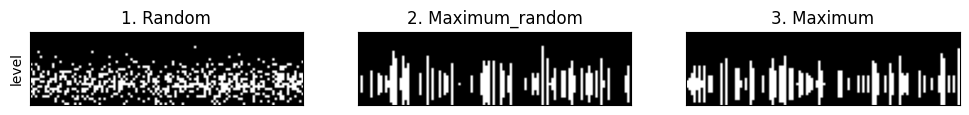

In [21]:
fig,axes = plt.subplots(1,3,figsize=(12,2),sharey=True)
for i in range(3):
    axes[i].imshow(CLDF[i][0][:,0].T,origin='lower',cmap='binary_r')
    axes[i].set_title(types[1+i])
    #axes[i].set_xlabel('g-points')
    axes[i].set_yticks([])
    axes[i].set_xticks([])
axes[0].set_ylabel('level')
#plt.suptitle('Cloud Fraction (1 sample)')

Text(0, 0.5, 'level')

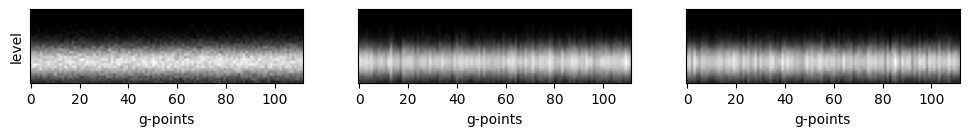

In [22]:
fig,axes = plt.subplots(1,3,figsize=(12,2))
for i in range(3):
    axes[i].imshow(CLDF[i].mean(axis=0)[:,0].T,origin='lower',cmap='binary_r')
    #axes[i].set_title(types[1+i])
    axes[i].set_xlabel('g-points')
    axes[i].set_yticks([])
axes[0].set_ylabel('level')
#plt.suptitle('Cloud Fraction (average)')